# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following textension boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
import pickle
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plot
#import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
#import cv2
import hashlib
import os
from urllib.request import urlretrieve
from PIL import Image
from sklearn.utils import resample
from tqdm import tqdm
from zipfile import ZipFile
from PIL import Image
import matplotlib.gridspec as gridspec

from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import glob, os
import random


In [2]:
# Load pickled data

training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
    #print(train)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    #print (test)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

print (X_train.shape)

(39209, 32, 32, 3)


In [3]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
images = X_train[0]
images_shape = np.shape(images)

# TODO: how many classes are in the dataset
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", images_shape)
print("Number of classes =", n_classes)



Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [4]:
#Load 5 images and make them 32x32 RGB images

size = 32, 32

my_test_list = []

for infile in glob.glob("*.jpg"):
    file, extension = os.path.splitext(infile)
    img = Image.open(infile)
    im_rgb = img.convert('RGB')
    thumb = im_rgb.thumbnail(size, Image.ANTIALIAS)
    image = np.reshape(im_rgb, (32, 32, 3))
    my_test_list.append(image)
    
my_test_X = np.stack(my_test_list)
print(np.stack(my_test_X).shape)
    

#20,30,50,60,70
my_test_y = [0, 1, 2, 3, 4]

(5, 32, 32, 3)


In [5]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

In [6]:
#ax = sns.countplot(x="labels", data=train)

In [7]:
def show_images(images,row,col):
        
    #Split the figure in 3 rows and 3 columns to put images
    figure, axes = plot.subplots(row,col)
    
    # hspace vertical space reserve for white space between subplots
    # wspace horizontal space reserve for white space between subplots
    figure.subplots_adjust(hspace=0.0, wspace=0.0)
    
    for i, ax in enumerate(axes.flat):
        image_shape = np.shape(images[i])
        ax.imshow(images[i].reshape(image_shape), cmap='binary')

        ax.set_xticks([])
        ax.set_yticks([])
        
    plot.show()

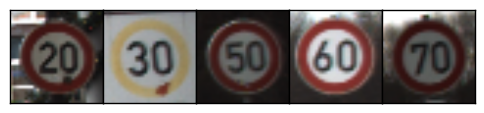

In [8]:
indexes = []
selection = []

for i in range(5):
    indexes.append(np.max(np.nonzero(y_train == i)))
    
for index in  indexes:
    image = X_train[index]
    selection.append(image)
    
show_images(selection,1,5)

Loading...: 100%|██████████| 43/43 [00:29<00:00,  1.39labels/s]


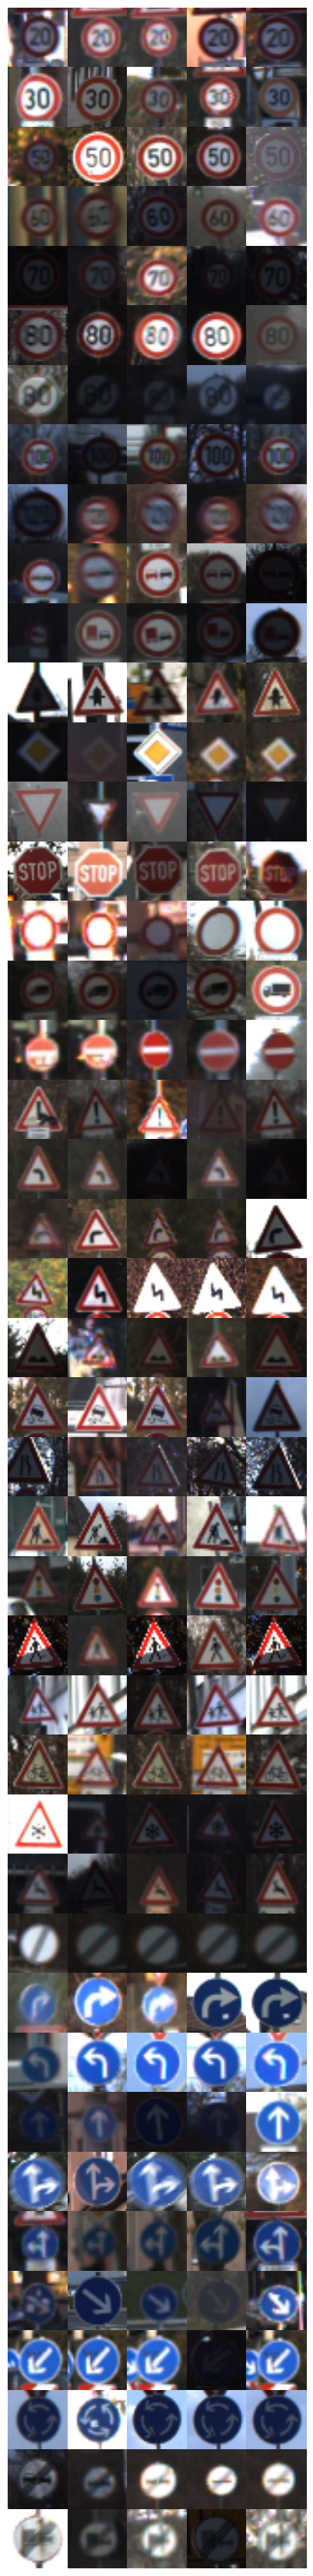

In [9]:
sample = 5
counter = 0 
fig = plot.figure(figsize=(sample, n_classes))
grid = gridspec.GridSpec(n_classes, sample, wspace=0.0, hspace=0.0)
labelset_pbar = tqdm(range(n_classes), desc='Loading...', unit='labels')
for i in labelset_pbar:
    ind = y_test == i
    subset_x = X_test[ind,] 
    for x in range(sample):
        img = random.choice(subset_x)
        ax = plot.Subplot(fig, grid[counter])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img, cmap='gray')
        fig.add_subplot(ax)
        counter +=1
    if i == (n_classes-1):
        axes = fig.get_axes()
        for ax in axes:
            for sp in ax.spines.values():
                sp.set_visible(False)
plot.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [10]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

In [11]:
#Y'=0.299R'+0.587G'+0.114B'

def grayscale(array):
    greyscale_data = []

    for i in range(0,array.shape[0]):
        image = array[i]    
        red,green,blue =image[:,:,0], image[:,:,1], image[:,:,2]
        grey_image = 0.2989 * red + 0.5870 *green  + 0.1140 *blue
        greyscale_data.append(grey_image)
        
        
    return np.array(greyscale_data)

X_train = grayscale(X_train)
X_test = grayscale(X_test)

print (X_train.shape)
print (X_test.shape)


(39209, 32, 32)
(12630, 32, 32)


In [12]:
#FOR STEP 3
my_test_X  = grayscale(my_test_X )
print (my_test_X.shape)

(5, 32, 32)


In [13]:
def flatten_gray(array):
    flat_data = []
    
    for i in range(0,array.shape[0]):
        image = array[i]
        #Return a copy of the array collapsed into one dimension.
        data = np.array (image, dtype = np.float32).flatten()
        flat_data.append(data)
        
    return np.array(flat_data)

X_train = flatten_gray(X_train)
X_test = flatten_gray(X_test)



print (X_train.shape)
print (X_test.shape)


(39209, 1024)
(12630, 1024)


In [14]:
#FOR STEP 3
my_test_X  = flatten_gray(my_test_X )
print (my_test_X.shape)

(5, 1024)


In [15]:
def normalize_greyscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    # ToDo: Implement Min-Max scaling for greyscale image data
    #costants
    a = 0.1
    b = 0.9
    xmin = 0
    xmax = 255
    
    x = image_data    
    x_prime = a + ((x-xmin)*(b-a))/(xmax-xmin)
    
    return x_prime



X_train = normalize_greyscale(X_train)
X_test = normalize_greyscale(X_test)



print (X_train.shape)
print (X_test.shape)


(39209, 1024)
(12630, 1024)


In [16]:
#FOR STEP 3
my_test_X = normalize_greyscale(my_test_X )
print (my_test_X.shape)

(5, 1024)


In [17]:
# Turn labels into numbers and apply One-Hot Encoding
encoder = LabelBinarizer()
encoder.fit(y_train)
#clases = encoder.classes_
#print (clases)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

# Change to float32, so it can be multiplied against the features in TensorFlow, which are float32

y_train = y_train.astype(np.float32)

y_test = y_test.astype(np.float32)
print (X_train.shape)

(39209, 1024)


In [18]:
my_test_y = encoder.transform(my_test_y)
my_test_y = my_test_y.astype(np.float32)

print (my_test_y.shape)

(5, 43)


In [19]:
# Get randomized datasets for training and validation

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,test_size=0.15,random_state=832289)

print('Training features and labels randomized and split.')

Training features and labels randomized and split.


In [20]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [21]:
import tensorflow as tf
sess = tf.InteractiveSession()

In [22]:
#creating nodes for the input images and target output classes.
x = tf.placeholder(tf.float32, shape=[None, 1024])
y_ = tf.placeholder(tf.float32, shape=[None, 43])

In [23]:
#define the weights W and biases b for model
W = tf.Variable(tf.zeros([1024,43]))
b = tf.Variable(tf.zeros([43]))

In [24]:
#Create random weights with zero mean and standard deviation sigma 
#Select a small standard deviation, so that the distributions is very uncertain and improve over time

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    
    return tf.Variable(initial)

#Create bias initialized in zero.
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    
    return tf.Variable(initial)

In [25]:
#Function for Convolution
def conv2d(x, W):
    
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

In [26]:
#Function for MAX-pooling
def max_pool_2x2(x):
    
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [27]:
#First Convolutional Layer
#The convolutional will compute 32 features for each 5x5 patch
W_conv1 = weight_variable([5, 5, 1, 32])

#The bias vector has a component for each output channel.
b_conv1 = bias_variable([32])

In [28]:
#Image shape 32x32, and 1 channel because the image is in Grayscale
#Reshape x to a 4d tensor
x_image = tf.reshape(x, [-1,32,32,1])
#print(tf.shape(x_image))

In [29]:
#Apply a one liner to convolve the x_image with weight tensor and add the bias. Apply the ReLu function.
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

#finally Max pooling
h_pool1 = max_pool_2x2(h_conv1)

In [30]:
#Second Convolutional Layer
#64 features for each 5x5 patch.
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

In [31]:
#Fully Connected Layer with 1024 neurons
W_fc1 = weight_variable([8 * 8 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [32]:
#Dropout, in order to reduce overfitting.

#placeholder of the probability that the neuron is kept during dropout
keep_prob = tf.placeholder(tf.float32)

h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [33]:
#Readout layer

W_fc2 = weight_variable([1024, 43])
b_fc2 = bias_variable([43])

#Logits
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2  


In [34]:
#Average cross-entropy --> Loss 
# tf.nn.softmax_cross_entropy_with_logits(logits, labels, dim=-1, name=None)
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))

#learning_rate = 9e-4
## This is the method used to train the model
train_step = tf.train.AdamOptimizer(8.8e-4).minimize(cross_entropy)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
 
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.initialize_all_variables())



# Train and Evaluate the model

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

I first converted the image from RGB to grayscale, since the data doesn't depend on the colors on the image it is easier to work with just 1 channel.
Then I normalize the data in order to have data with zero mean and equal variance and also to avoid having very small numbers.

In [35]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

I used the function train_test_split from sklearn, which splits the input arrays into random train and test subsets according to the percentage requested. In this case I selected 15% of the data.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


I used a Convnet with 2 layers. 

It inputs the preprocess image to a Convolutional Layer and then the output of this first layer goes into a second convolutional layer and then to a Fully Connected layer. Finally a classification layer  is created.

The first convolutional layer will compute 32 features for each 5x5 patch.
The second convolutional layer will computer 64 features for each 5x5 patch.


**Answer:**

In [36]:
### Train your model here.
### Feel free to use as many code cells as needed.

In [37]:
import datetime


batch_size= 40
total_samples = X_train.shape[0]
epochs = 5
#Loops (at batch size) to get through data once.
loops = int(total_samples / batch_size) 

print("Start ",datetime.datetime.now().time())

for i in range(epochs):
    for j in range(loops):
        batch_start = j*batch_size
        batch_features = X_train[batch_start:(batch_start + batch_size)]
        batch_labels = y_train[batch_start:(batch_start + batch_size)] 
        
        
        if j%100 == 0:
            train_accuracy = accuracy.eval(feed_dict={x:batch_features, y_: batch_labels, keep_prob: 1.0})
            print("step %d, training accuracy %g, batch start %d"%(j, train_accuracy, batch_start))
        
        
        
        train_step.run(feed_dict={x: batch_features, y_: batch_labels, keep_prob: 0.5})

    print("valid accuracy %g"%accuracy.eval(feed_dict={x: X_valid, y_: y_valid, keep_prob: 1.0}))

    
    
print("test accuracy %g"%accuracy.eval(feed_dict={x: X_test, y_: y_test, keep_prob: 1.0}))    

print ("Finished ", datetime.datetime.now().time())

Start  15:19:47.287112
step 0, training accuracy 0.025, batch start 0
step 100, training accuracy 0.275, batch start 4000
step 200, training accuracy 0.625, batch start 8000
step 300, training accuracy 0.675, batch start 12000
step 400, training accuracy 0.775, batch start 16000
step 500, training accuracy 0.65, batch start 20000
step 600, training accuracy 0.875, batch start 24000
step 700, training accuracy 0.9, batch start 28000
step 800, training accuracy 0.9, batch start 32000
valid accuracy 0.893404
step 0, training accuracy 0.95, batch start 0
step 100, training accuracy 0.925, batch start 4000
step 200, training accuracy 1, batch start 8000
step 300, training accuracy 0.925, batch start 12000
step 400, training accuracy 1, batch start 16000
step 500, training accuracy 0.875, batch start 20000
step 600, training accuracy 0.975, batch start 24000
step 700, training accuracy 0.975, batch start 28000
step 800, training accuracy 0.95, batch start 32000
valid accuracy 0.964638
step 0

In [38]:
print(my_test_y.shape)

print("test accuracy %g"%accuracy.eval(feed_dict={x: my_test_X, y_: my_test_y , keep_prob: 1.0}))

(5, 43)
test accuracy 0.4


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

Optimizer: AdamOptimizer
Batch size: 40
epochs:5
learning rate : 8.8e-4


### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

I used as a base the tutorial from tensorflow for the MNIST. From there I adjusted the sizes of tensors to fit my data and create additional helper functions. For example functons to change rgb to grayscale without using cv2 since is not available in docker, show images, etc.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [39]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

(5, 32, 32, 3)


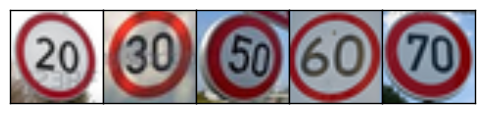

In [40]:
size = 32, 32

my_test_list_images = []

for infile in glob.glob("*.jpg"):
    file, extension = os.path.splitext(infile)
    img = Image.open(infile)
    rgb_img = img.convert('RGB')
    thumb = rgb_img.thumbnail(size, Image.ANTIALIAS)
    image = np.reshape(rgb_img, (32, 32, 3))
    my_test_list_images.append(image)
    
my_test_images = np.stack(my_test_list_images)
print(np.stack(my_test_images).shape)

show_images(my_test_list_images,1,5)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

There are some shadows on the new images that could confuse the model as in the 30km/h image. Some of the new images have an angle as for example the 50km/h image, this could be difficult for the classification. For the 60km/h image the black color is a little bit blur so that may be a problem.

In [41]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

In [42]:
#Dictionary that contains label with signname
label_to_name_map = {}
with open("signnames.csv", mode='r') as f:
    for line in f:
        parts = line.strip().split(',')
        if parts[0] == 'ClassId':
            continue
        label_to_name_map[int(parts[0])] = parts[1]

In [43]:
#Converts my_test_y into signames.
my_test_y_labels = []
for j in range(0,5):
    my_test_y_labels.append(label_to_name_map[j])
    
print(my_test_y_labels)
    

['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)']


In [44]:

    

predictions = tf.argmax(y_conv,1)
for i in range(0,5):
    prediction = predictions.eval(feed_dict={x: [my_test_X[i]], keep_prob: 1.0})
    label = label_to_name_map[prediction[0]]
    real_label = my_test_y_labels[i]
    if label == real_label:
        status = "Correct"
        
    else:
        status = "Incorrect"
        
    print("Image predicted:", label, "- Real image:","\t", real_label,"\t", status)
        

Image predicted: Speed limit (20km/h) - Real image: 	 Speed limit (20km/h) 	 Correct
Image predicted: Speed limit (30km/h) - Real image: 	 Speed limit (30km/h) 	 Correct
Image predicted: Speed limit (30km/h) - Real image: 	 Speed limit (50km/h) 	 Incorrect
Image predicted: Speed limit (50km/h) - Real image: 	 Speed limit (60km/h) 	 Incorrect
Image predicted: Speed limit (80km/h) - Real image: 	 Speed limit (70km/h) 	 Incorrect


### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

No, it didn't perform as well as the dataset. Since my images are with different angles, shadows and so on. I think my model gets confused.
With the dataset I obtained an ccuracy of 91% and when tested in the 5 images I got just 40% of accuracy.

In [45]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

In [46]:
probabilities = y_conv
prob_list = []

for i in range(0,5):   
    a = sess.run(tf.nn.top_k(tf.nn.softmax(probabilities.eval(feed_dict={x: [my_test_X[i]],
                                                                                        keep_prob: 1.0},
                                                                             session=sess)), k=5))
    values = list(a.values[0])
    indices = list(a.indices[0])
    maximum = max(values)
    rest = np.sum(values)-maximum
    print("Image%g-Probabilities:"%i, values , "Predicted Image:", indices )
    print("Max:%f"%maximum, "Others:%f"%rest) #, maximum+rest

    if i in indices:
        print("Image is in the top 5 predictions")
    else:
        print("Image is NOT in the top 5 predictions")
        
    print()
    


Image0-Probabilities: [0.99942821, 0.00044729534, 8.4061699e-05, 2.7325501e-05, 7.1971376e-06] Predicted Image: [0, 1, 38, 32, 5]
Max:0.999428 Others:0.000566
Image is in the top 5 predictions

Image1-Probabilities: [0.9978916, 0.001771484, 0.00032042162, 1.0408814e-05, 5.0025455e-06] Predicted Image: [1, 5, 31, 2, 3]
Max:0.997892 Others:0.002107
Image is in the top 5 predictions

Image2-Probabilities: [0.87326044, 0.085645452, 0.035932358, 0.0030470481, 0.0020798254] Predicted Image: [1, 2, 8, 0, 40]
Max:0.873260 Others:0.126705
Image is in the top 5 predictions

Image3-Probabilities: [0.90640169, 0.04699919, 0.017441008, 0.01084632, 0.0071788142] Predicted Image: [2, 31, 3, 38, 33]
Max:0.906402 Others:0.082465
Image is in the top 5 predictions

Image4-Probabilities: [0.99278039, 0.0060765049, 0.0008082639, 0.00016326756, 6.5323002e-05] Predicted Image: [5, 4, 1, 3, 6]
Max:0.992780 Others:0.007113
Image is in the top 5 predictions



### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

In most of the cases the prediction was on the top 5 predictions. 

For image 0, we can see that the model was very certain (99%) of the correct image. The prediction was correct.
For image 1, we can see that the model was very certain (99%) of the correct image. The prediction was correct.
For image 2, the certainty was high for the prediction, however there was a 1/8 of probability of not being correct image.  however the prediction was not correct. At least in this case the correction prediction was on the top 2 "k".
For image 3, the certainty was high for the prediction, however the prediction was not correct. At least in this case the correction prediction was on the top 3 "k".
For image 4, the certainty was high for the prediction, however the prediction was not correct. At least in this case the correction prediction was on the top 2 "k".



### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

In [48]:
# Save the data for easy access
pickle_file = 'Traffic.pickle'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open('Traffic.pickle', 'wb') as pfile:
            pickle.dump(
                {
                    'train_dataset': X_train,
                    'train_labels': y_train,
                    'valid_dataset': X_valid,
                    'valid_labels': y_valid,
                    'test_dataset': X_test,
                    'test_labels': y_test,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

Data cached in pickle file.


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.